# Compile a pretrained BERT model
## Define all preprocessing steps

In [8]:
#!pip install transformers

In [34]:
import pandas as pd
data = pd.read_csv('data/movies_metadata.csv', low_memory=False)

In [35]:
data = data.dropna(subset = ['overview'])
len(data)

44512

### extract the 1st genre from the 'name' column

In [36]:
import numpy as np
genre_1 = []
for var in data.genres:
  if var != '[]':
    df = pd.DataFrame(eval(var))
    genre_1.append(df.iloc[0]['name'])
  else:
    genre_1.append(np.nan)

In [37]:
data['first_genre'] = genre_1

In [38]:
data = data[['overview', 'first_genre']]

### Check the length of the labels array

In [39]:
print('different labels', len(data['first_genre'].value_counts()))

different labels 23


In [15]:
data = data.dropna(subset = 'first_genre')
len(data)

940

In [28]:
data['overview'] = data['overview'].str.lower()
data = data[['overview', 'first_genre']]

### Encode the target variable with LabelEncoder

In [40]:
from sklearn.calibration import LabelEncoder
lb = LabelEncoder()
data['first_genre'] = lb.fit_transform(data.first_genre)

In [30]:
from sklearn.model_selection import train_test_split
X = data['overview'].tolist()
y = data['first_genre'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [9]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", do_lower_case=True)

In [32]:
max_length = 200
truncation=True
padding = "max_length"
train_encodings = tokenizer(X_train, padding=padding, truncation=truncation, return_tensors="tf")
val_encodings = tokenizer(X_val, padding=padding, truncation=truncation, return_tensors="tf")
test_encodings = tokenizer(X_test,  padding=padding, truncation=truncation, return_tensors="tf")

In [33]:
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

In [34]:

from transformers import TFDistilBertForSequenceClassification
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=20, output_attentions = False,
    output_hidden_states = False)


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use i

In [35]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.007)
metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  15380     
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
Total params: 66,968,852
Trainable params: 66,968,852
Non-trainable params: 0
_________________________________________________________________


In [16]:
BATCH_SIZE = 16
EPOCHS = 5

In [17]:
history = model.fit(
    train_dataset.batch(BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=val_dataset.batch(BATCH_SIZE)
)

Epoch 1/5
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
33/33 [==============================] - 1183s 36s/step - loss: 2.6942 - accuracy: 0.1920 - val_loss: 2.3927 - val_accuracy: 0.2611
Epoch 2/5
33/33 [==============================] - 1179s 36s/step - loss: 2.5140 - accuracy: 0.2510 - val_loss: 2.5243 - val_accuracy: 0.2168
Epoch 3/5
16/33 [=============>................] - ETA: 8:52 - loss: 2.4295 - accuracy: 0.2852

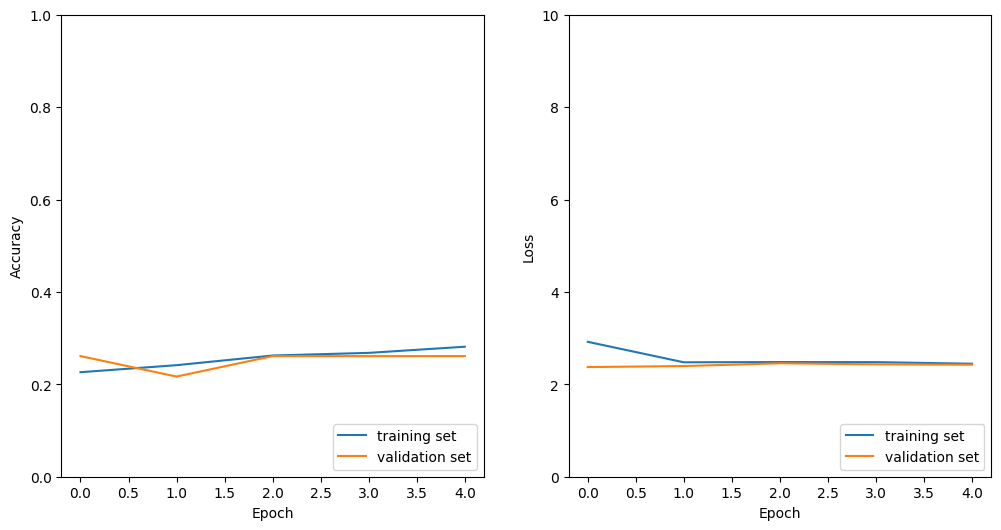

In [24]:
from matplotlib import pyplot as plt

def plot_history(history):
    """ This helper function takes the tensorflow.python.keras.callbacks.History
    that is output from your `fit` method to plot the loss and accuracy of
    the training and validation set.
    """
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].plot(history.history['accuracy'], label='training set')
    axs[0].plot(history.history['val_accuracy'], label = 'validation set')
    axs[0].set(xlabel = 'Epoch', ylabel='Accuracy', ylim=[0, 1])

    axs[1].plot(history.history['loss'], label='training set')
    axs[1].plot(history.history['val_loss'], label = 'validation set')
    axs[1].set(xlabel = 'Epoch', ylabel='Loss', ylim=[0, 10])
    
    axs[0].legend(loc='lower right')
    axs[1].legend(loc='lower right')
    
plot_history(history)

In [26]:
loss, accuracy = model.evaluate(test_dataset.batch(BATCH_SIZE))
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

12/12 [==============================] - 109s 9s/step - loss: 2.3696 - accuracy: 0.2926
Loss: 2.369603395462036
Accuracy: 0.292553186416626


In [4]:
from transformers import TFDistilBertForSequenceClassification
import tensorflow as tf
model = TFDistilBertForSequenceClassification.from_pretrained('my_model')

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



Some layers from the model checkpoint at my_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_79']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at my_model and are newly initialized: ['dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Get predictions

In [25]:
comment = ['The young and patriotic student Demachy joins the French army in 1914 to defend his country. But he and his comrades soon experience the terrifying, endless trench war in Champagne, where more and more wooden crosses have to be erected for this cannon fodder.']
test_comment1 = ["Dr. Vasi invents a super-powered robot, Chitti, in his own image. The scientific body, AIRD, that must approve the robot, declines it based on its not having emotions and the ability to make rational judgment. A sudden flash of lightning evokes emotions in the robot, and Chitti is seemingly ready for integration into the human world. Then, Chitti falls in love with Dr. Vasi fiancée Sana and turns on his creator."]

inputs0 = tokenizer(comment, truncation=True, padding=True, return_tensors='tf')
outputs0 = model(inputs0)
scores0 = tf.math.softmax(outputs0.logits).numpy()

inputs = tokenizer(test_comment1, truncation=True, padding=True, return_tensors='tf')
outputs = model(inputs)
scores = tf.math.softmax(outputs.logits).numpy()

### Analyze the scores from the predictions of the model

In [23]:
import numpy as np
# obtain position of max score
ids = np.argmax(scores, axis=-1)
# obtain the max score itself
values = np.max(scores, axis=-1)
# calculate the labels for each input
labels = list(map(lambda i: model.config.id2label[i], ids))
# print results as similar to a pipeline
for i in range(len(test_comment1)):
    
    print(dict([('label',labels[i]), ('score',values[i])]))

{'label': 'LABEL_3', 'score': 0.10738888}


In [42]:
def print_my_examples(inputs, results):
  # obtain position of max score
    ids = np.argmax(results, axis=-1)
    # obtain the max score itself
    values = np.max(results, axis=-1)
    # calculate the labels for each input
    labels = list(map(lambda i: model.config.id2label[i], ids))
    # print results as similar to a pipeline
    for i in range(len(inputs)):
        # strip the index and map it to the LabelEncoder
        value = labels[i].strip('LABEL_')
        print(lb.inverse_transform([int(value)])[0])
        print(dict([('label',labels[i]), ('score',values[i])]))

print_my_examples(outputs0, scores0)

Crime
{'label': 'LABEL_6', 'score': 0.10699504}
